In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#@title Utilities

import kornia
import torch
import torch.nn as nn
import torch.nn.functional as F
import requests
import PIL
import io
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from IPython.display import Image, HTML, clear_output, display
from ipywidgets import Output
import torch.nn as nn
import src

clear_output()

In [3]:
src.register_easy()

In [4]:
torch.__version__, kornia.__version__

('1.6.0', '0.5.11')

In [5]:
kornia.augmentation.RandomAffine??

/home/izpc/anaconda3/lib/python3.7/site-packages/kornia/augmentation/augmentation.py:2050: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output channels_last tensor even if some of the inputs are not in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:924.)
  return input + params['noise'].to(input.device) * self.std + self.mean
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


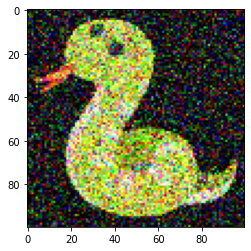

In [6]:
def get_noise(p=0.5):
    return nn.Sequential(
        kornia.augmentation.RandomAffine(
            degrees=[-20, 20],
            translate=[0.2, 0.2],
            scale=[1, 1],
            shear=[-5, 5],
            p=p,
        ),
        #     kornia.augmentation.RandomPerspective(0.6, p=1.0),
            kornia.augmentation.RandomGaussianNoise(mean=0, std=0.3, p=p),
    )

noise = get_noise()
img_np, img_pil = src.load_emoji('🐍')
img_ez_tensor = torch.tensor(img_np).ez.usq().chw.raw
x = torch.cat([img_ez_tensor, torch.rand(1, 10, 100, 100)], dim=1)
x = noise(x)[:, :].ez.hwc.raw[0, :, :, :3]
# x = x + torch.randn_like(x) / 2
x.ez.imshow()

((32, 32, 1), 0.31625497, 0.74059016)

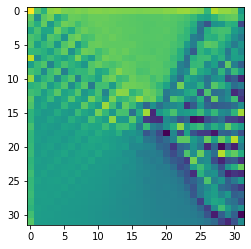

In [7]:
msg_size = 20
ca_depth = 32
image_channels = 1

encoder = src.CAEncoder(num_chanels=ca_depth)
decoder = src.Decoder(in_channels=image_channels, output_size=msg_size)

noisy_channel = src.NoisyChannel(
    msg_size=msg_size,
    seed_shape=[ca_depth, 32, 32],
    encoder=encoder,
    decoder=decoder,
    num_decode_channels=image_channels,
    
).to('cuda')

loss_history = []

out = noisy_channel.forward(bs=1, steps=40)
out = out[:,-1,:image_channels,:,:]
out = out.ez.hwc.np[0]
plt.imshow(out)
out.shape, out.min(), out.max()

In [8]:
vid = src.generate_video(noisy_channel)
vid

In [9]:
#@title Training {vertical-output: true}
import time

out = Output()
display(out)

tq = tqdm(range(10001))
p = 0.0

for i in tq:
    steps = 40 + i // 100
    noise = get_noise(p=p)
    loss = noisy_channel.training_step(bs=8, noise=noise, steps=steps)
    if np.mean(loss_history[-500:]) < 0.3:
        p += 0.05
    tq.set_description(f'Loss: {loss:.6f}')
    loss_history.append(loss)

    with out:
        if i % 100 == 0:
            clear_output(wait=True)
            torch.save(noisy_channel, 'model.pk')
            vid = src.generate_video(noisy_channel)
            print(f'P={p}')

            src.plot_loss(loss_history)
            display(vid)

Output()

/home/izpc/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/izpc/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

In [ ]:
vid = src.generate_video(noisy_channel)
vid

In [ ]:
a, b = torch.rand(6, 10, 10).chunk(2, dim=0)
a.shape, b .shape

In [ ]:
from matplotlib import cm

In [ ]:
x = np.random.rand(10, 10)
x = cm.jet(x)
plt.imshow(x)

In [ ]:
t = torch.rand(10, 10)

In [ ]:
t.normal_(0, 0)